In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

In [3]:
import geopandas as gpd
plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [4]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [5]:
df = df[df.date >= '2021-11-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x in ['B.1.1.529','BA.1','BA.2'])))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [6]:
df_filtered

sending_pc       date  all  omi  days  sending_area  sending_pc_ID  \
0          01067 2021-11-01    0    0   -73             0              0   
1          01067 2021-11-02    8    0   -72             0              0   
2          01067 2021-11-03    0    0   -71             0              0   
3          01067 2021-11-04   69    0   -70             0              0   
4          01067 2021-11-05    0    0   -69             0              0   
...          ...        ...  ...  ...   ...           ...            ...   
17471      90530 2022-01-03    2    1   -10             9             94   
17472      90530 2022-01-04    2    1    -9             9             94   
17473      90530 2022-01-05    0    0    -8             9             94   
17474      90530 2022-01-06    0    0    -7             9             94   
17475      90530 2022-01-07    0    0    -6             9             94   

      bundesland  
0        Sachsen  
1        Sachsen  
2        Sachsen  
3        Sachsen  
4        Sachsen  
...          ...  
17471     Bayern  
17472     Bayern  
17473     Bayern  
17474     Bayern  
17475     Bayern  

[7548 rows x 8 columns]

Text(0, 0.5, 'Proportion')

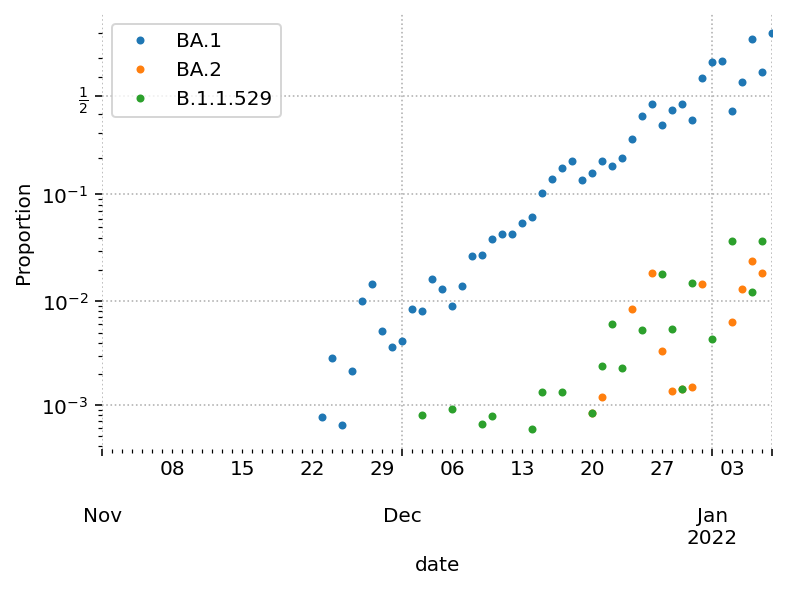

In [7]:
foo = pd.crosstab(df.date, df.lineage.cat.remove_unused_categories())
for i in ['BA.1','BA.2','B.1.1.529']:
    (foo[i]/foo.sum(1)).plot(ls="",marker='.', label=i)
plt.yscale('logit')
plt.legend()
plt.ylabel('Proportion')

In [8]:
print(foo.loc["2021-12-01":,:].sum(0).sort_values().to_string())

lineage
B                0
AY.37            0
AY.46.4          0
AY.52            0
AY.55            0
AY.66            0
AY.67            0
AY.107           0
AY.89            0
AY.91.1          0
AY.23.2          0
AY.5.2           0
AY.16            0
B.1.1.7          0
AY.27            0
AY.3.1           0
AU.2             0
AY.43.2          0
B.1.351          0
AY.43.3          0
B.1.639          0
AY.46.3          0
AY.53            1
AY.54            1
AY.50            1
AY.58            1
AY.60            1
BA.3             1
B.1.1.263        1
AY.11            1
AY.39.1.1        1
AY.82            1
AY.95            1
AY.99.2          1
AY.19            1
AY.119.1         1
AY.23.1          1
AY.46.5          1
AY.77            1
AY.104           1
AY.68            1
AY.105           1
AY.62            1
AY.93            1
B.1.1            1
AY.101           1
AY.13            1
B.1.110          1
AY.87            2
AY.71            2
AY.70            2
AY.56            2
AY.4

(18951.0, 19005.0)

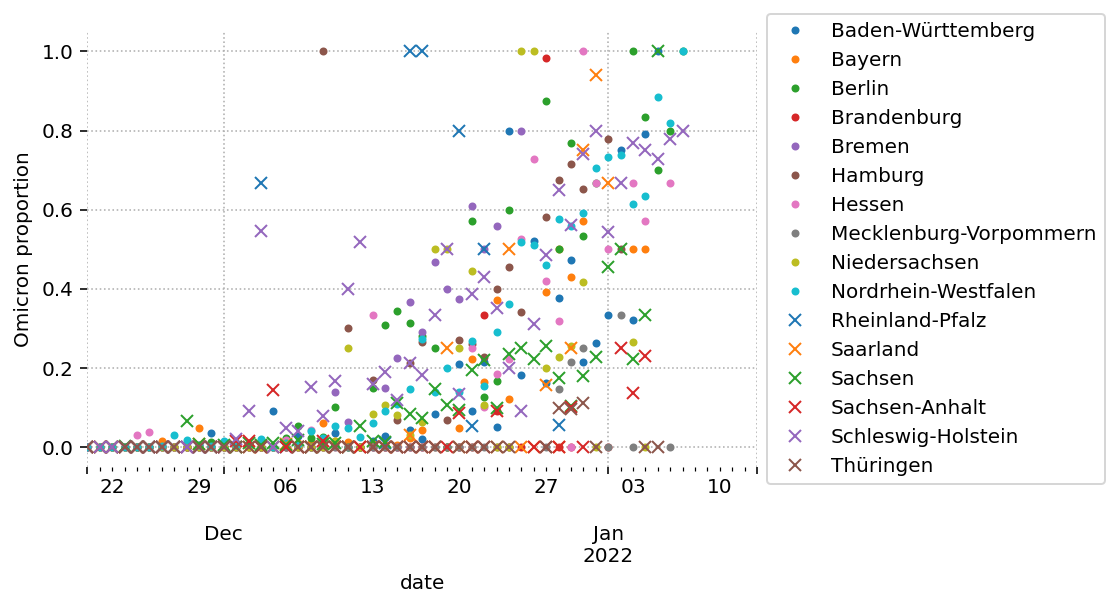

In [9]:
omi_bl = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
omi_bl = omi_bl.sum(level=[0,2]).loc[:,"2021-11-20":,:]
omi_bl['prop'] = omi_bl.omi / omi_bl['all']
for i,r in enumerate(omi_bl.index.levels[0]):
    omi_bl.loc[r]['prop'].plot(ls="", marker="." if i < 10 else "x", label=r)
#omi_bl.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')
plt.ylabel("Omicron proportion")
plt.xlim((None, np.datetime64("today")))

In [10]:
from numpyro.infer.reparam import LocScaleReparam

#reparam_config = {k: LocScaleReparam(0) for k in ["a_area", "a_lab", "b"]}

#@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sending_pc_to_area, sample_day, total_counts,omi_counts=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 5.0))
    sigma_a_area = numpyro.sample("sigma_a_area", dist.HalfNormal(5.0))
    sigma_a_lab = numpyro.sample("sigma_a_lab", dist.HalfNormal(2.))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.2, 0.2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(.1))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_pc_to_area))

    with numpyro.plate("plate_i", n_areas):
        a_area = numpyro.sample("a_area", dist.Normal(mu_a, sigma_a_area))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    with numpyro.plate("plate_j", n_labs):
        a_lab = numpyro.sample("a_lab", dist.Normal(0, sigma_a_lab)) 
    
    logit_est = a_lab[sending_pc] + a_area[sending_area] + b[sending_area] * sample_day

    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [11]:
sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc_ID, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

In [12]:
nuts_kernel = NUTS(model3)#, dense_mass=[("mu_a","mu_b","sigma_a_area","sigma_a_lab","sigma_b")])

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sending_area, sending_pc_to_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 7000/7000 [28:54<00:00,  4.03it/s, 1023 steps of size 3.93e-04. acc. prob=0.86]    


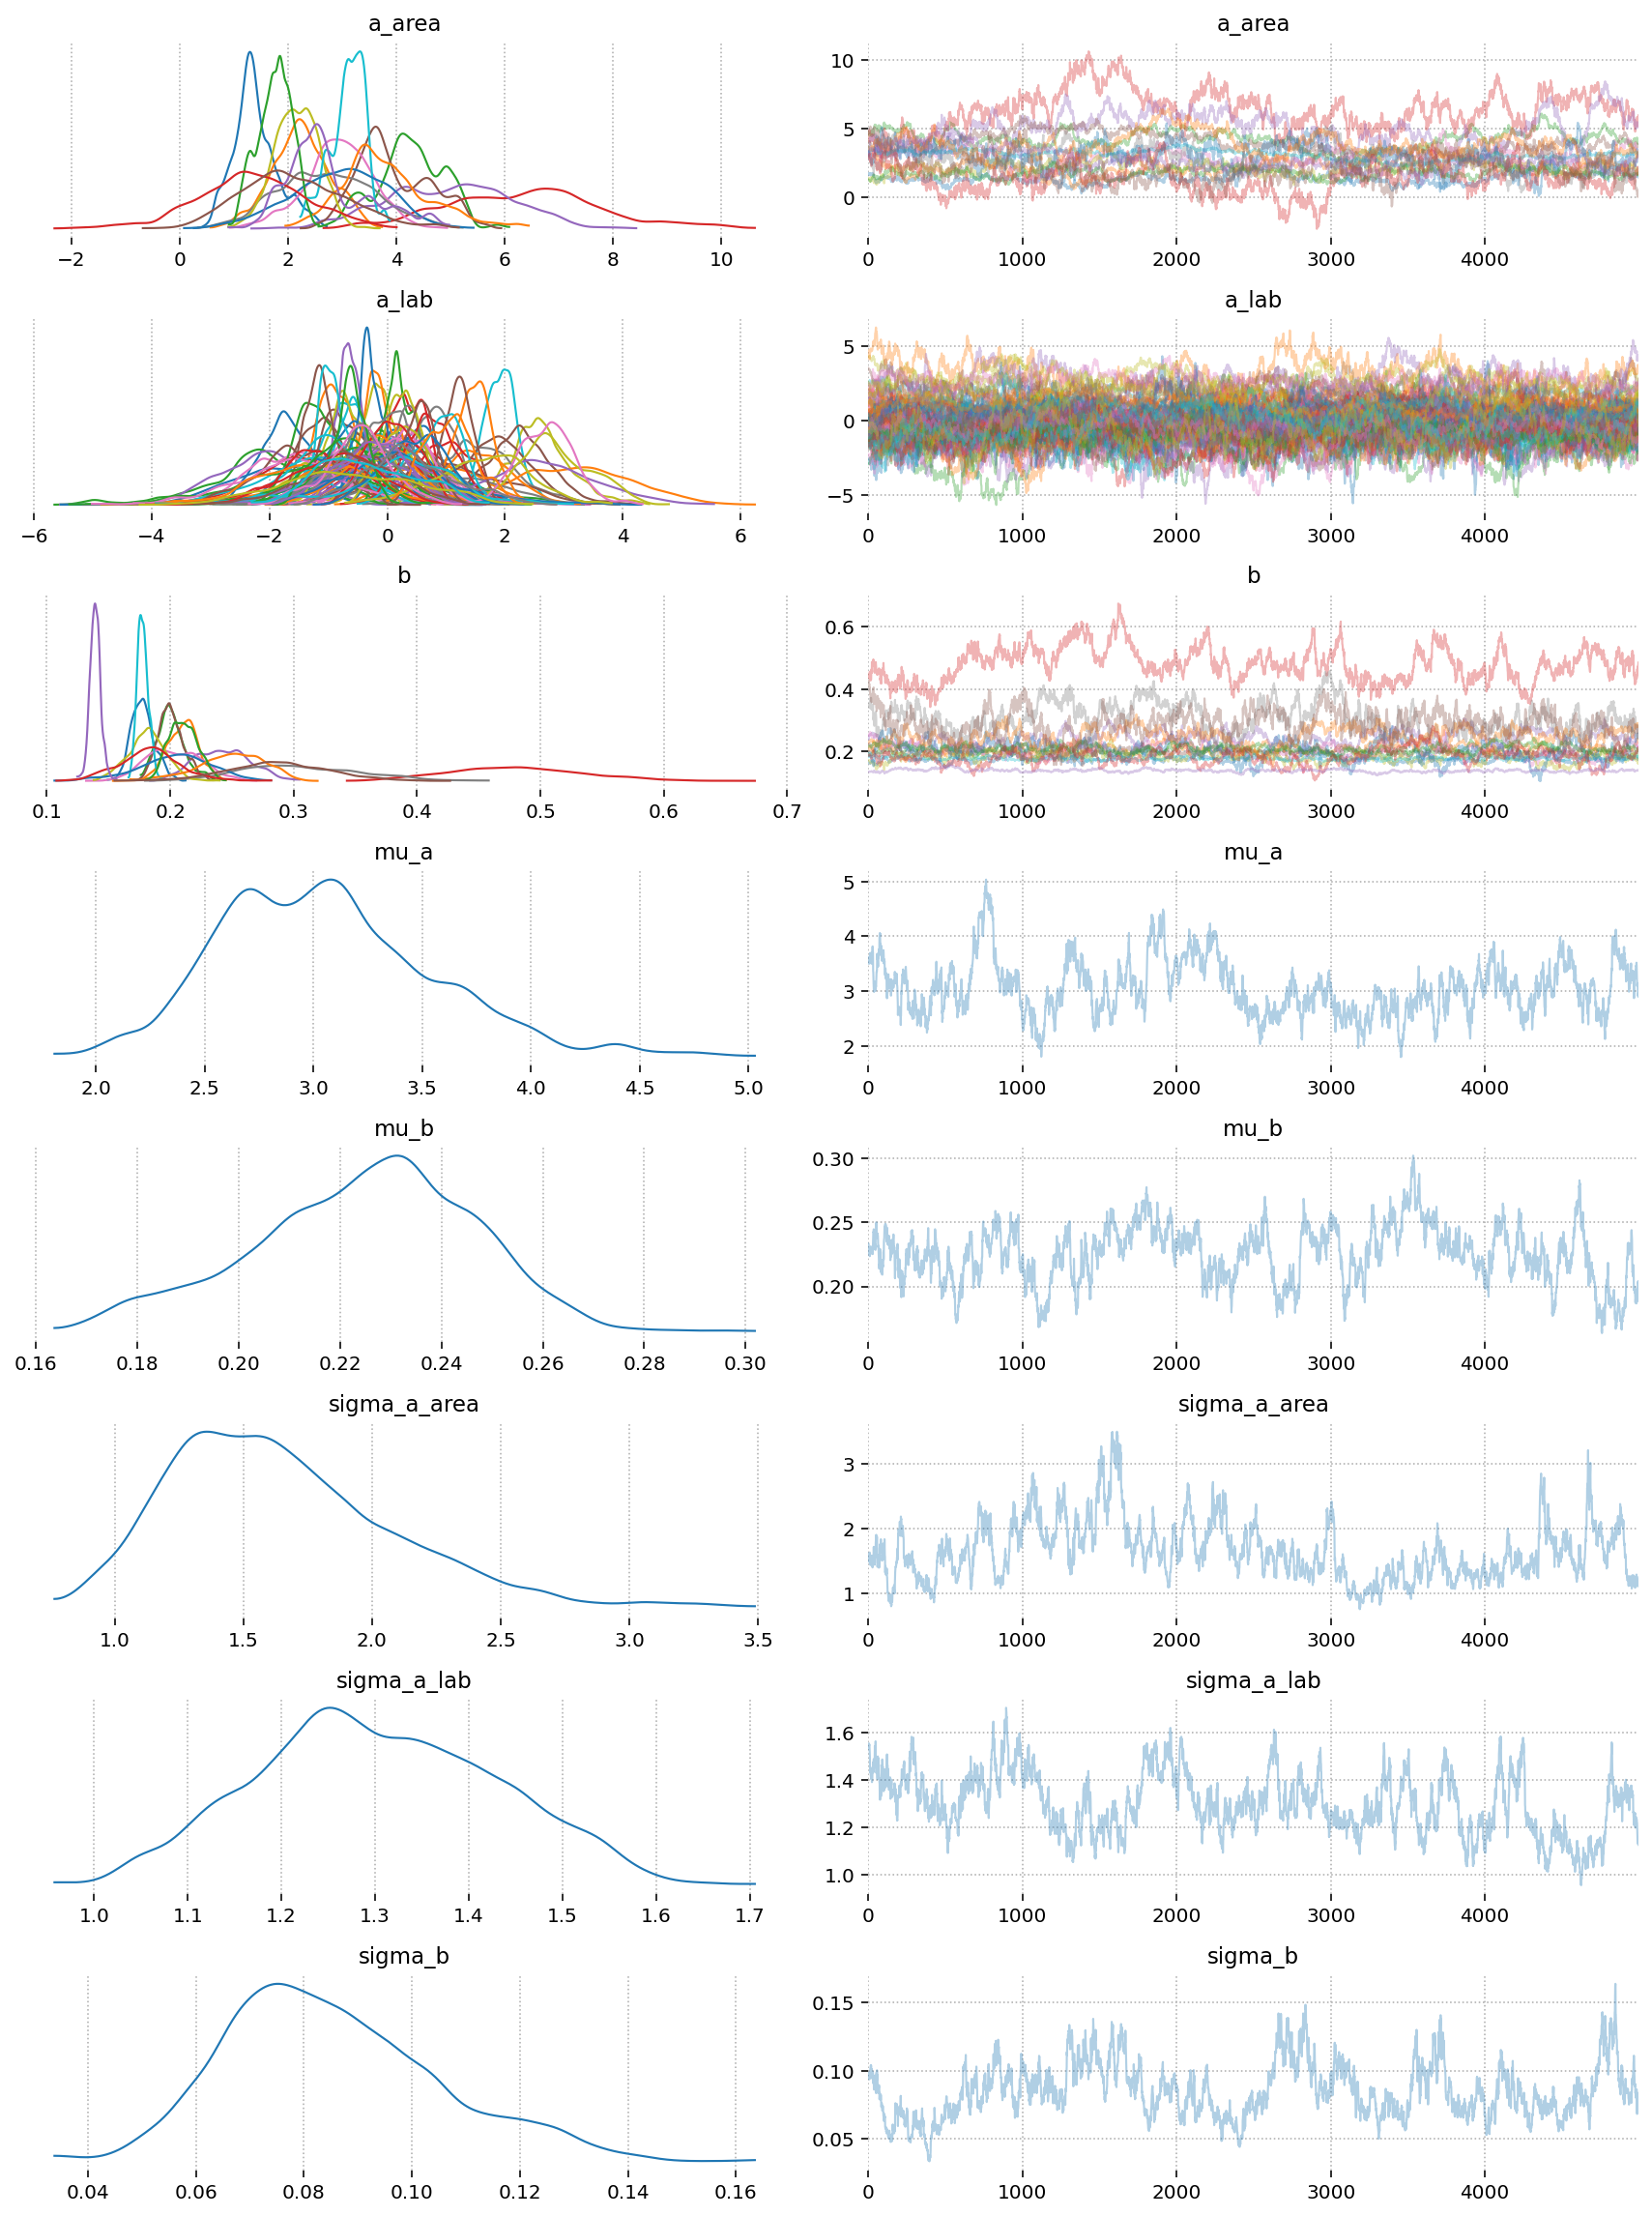

In [13]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [14]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
mcmc_summary = numpyro.diagnostics.summary(mcmc_samples)

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(mcmc_summary['mu_b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(mcmc_summary['mu_b']['5.0%'])-1:.1%}, {np.exp(mcmc_summary['mu_b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+mcmc_summary['mu_b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+mcmc_summary['mu_b']['95.0%']):.2},{np.log(2)/np.log(1+mcmc_summary['mu_b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    25.2% mit 90%-Konfidenzintervall [20.3%, 29.6%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    3.4 Tage mit 90%-Konfidenzintervall [3.0,4.1]
    


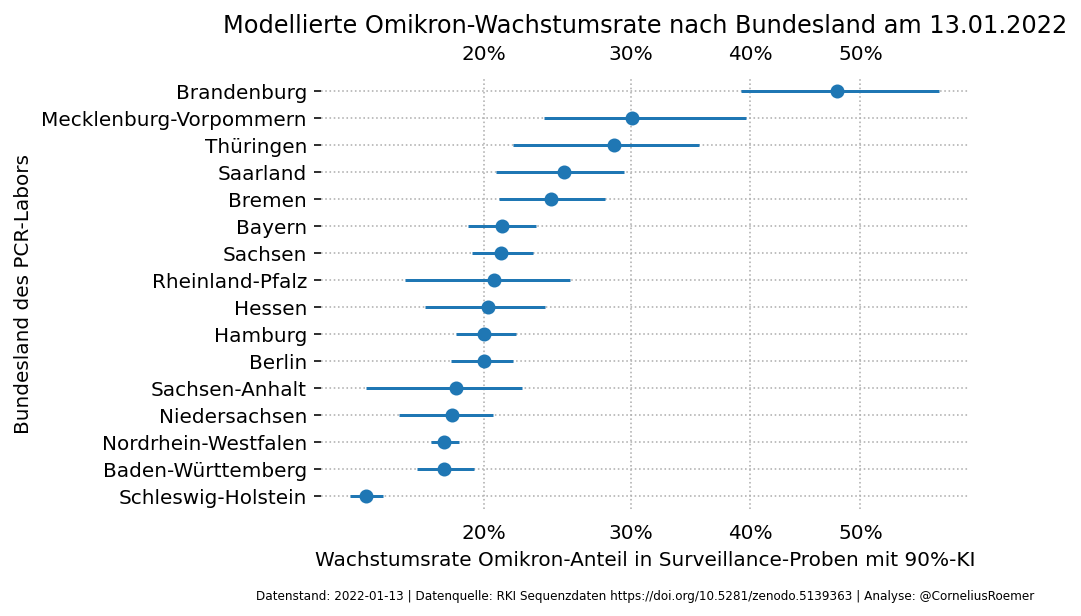

In [15]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(mcmc_summary['b'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([(pdf['median'])-(pdf['5.0%']),(pdf['95.0%'])-(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
#sns.set_theme(style="whitegrid")
ax.errorbar(x=(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
#sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierte Omikron-Wachstumsrate nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Wachstumsrate Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [16]:
list(df_filtered.bundesland.values.categories)

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

In [17]:
q = [0.05,0.5,0.95]
t = (np.arange("2021-12-01","2022-01-31", dtype='datetime64[D]') - np.datetime64("today")).astype("int")
prop_bl = pd.Series(expit(np.quantile(mcmc_samples['a_area'][0][...,np.newaxis] + mcmc_samples['b'][0][...,np.newaxis] * t[np.newaxis,np.newaxis,:], 
                                     q,
                                     axis = 0)).flatten(),
                         index = pd.MultiIndex.from_product([q, 
                                                             df_filtered.bundesland.values.categories,
                                                             np.datetime64("today") + t.astype("timedelta64[D]")],
                                                           names=['quantile',
                                                                  'bundesland',
                                                                  'date']),
                       )
prop_bl = prop_bl.reset_index().set_index(["bundesland","date","quantile"])#.pivot(columns="quantile")

In [18]:
prop_bl

0
bundesland        date       quantile          
Baden-Württemberg 2021-12-01 0.05      0.001026
                  2021-12-02 0.05      0.001243
                  2021-12-03 0.05      0.001506
                  2021-12-04 0.05      0.001816
                  2021-12-05 0.05      0.002193
...                                         ...
Thüringen         2022-01-26 0.95      0.999730
                  2022-01-27 0.95      0.999809
                  2022-01-28 0.95      0.999866
                  2022-01-29 0.95      0.999907
                  2022-01-30 0.95      0.999934

[2928 rows x 1 columns]

In [19]:
omi_bl.loc[r]['prop']

date
2021-11-20    0.000000
2021-11-21         NaN
2021-11-22         NaN
2021-11-23    0.000000
2021-11-24    0.000000
2021-11-25    0.000000
2021-11-26    0.000000
2021-11-27    0.000000
2021-11-28         NaN
2021-11-29    0.000000
2021-11-30    0.000000
2021-12-01    0.000000
2021-12-02    0.000000
2021-12-03    0.000000
2021-12-04    0.000000
2021-12-05         NaN
2021-12-06         NaN
2021-12-07    0.000000
2021-12-08    0.000000
2021-12-09    0.000000
2021-12-10    0.000000
2021-12-11    0.000000
2021-12-12         NaN
2021-12-13    0.000000
2021-12-14    0.000000
2021-12-15    0.000000
2021-12-16    0.000000
2021-12-17    0.000000
2021-12-18    0.000000
2021-12-19         NaN
2021-12-20    0.000000
2021-12-21    0.000000
2021-12-22    0.000000
2021-12-23    0.000000
2021-12-24    0.000000
2021-12-25         NaN
2021-12-26         NaN
2021-12-27    0.000000
2021-12-28    0.098361
2021-12-29    0.096774
2021-12-30    0.111111
2021-12-31    0.000000
2022-01-01         NaN
2022-0

In [20]:
omi_bl

all  omi  days  sending_area  sending_pc_ID  \
bundesland        date                                                      
Baden-Württemberg 2021-11-20  119    0  -648            84            972   
                  2021-11-21   92    0  -636            84            972   
                  2021-11-22  534    0  -624            84            972   
                  2021-11-23  112    0  -612            84            972   
                  2021-11-24   46    0  -600            84            972   
...                           ...  ...   ...           ...            ...   
Thüringen         2022-01-03    0    0   -40            27            312   
                  2022-01-04    3    0   -36            27            312   
                  2022-01-05    3    0   -32            27            312   
                  2022-01-06    0    0   -28            27            312   
                  2022-01-07    0    0   -24            27            312   

                              prop  
bundesland        date              
Baden-Württemberg 2021-11-20   0.0  
                  2021-11-21   0.0  
                  2021-11-22   0.0  
                  2021-11-23   0.0  
                  2021-11-24   0.0  
...                            ...  
Thüringen         2022-01-03   NaN  
                  2022-01-04   0.0  
                  2022-01-05   0.0  
                  2022-01-06   NaN  
                  2022-01-07   NaN  

[784 rows x 6 columns]

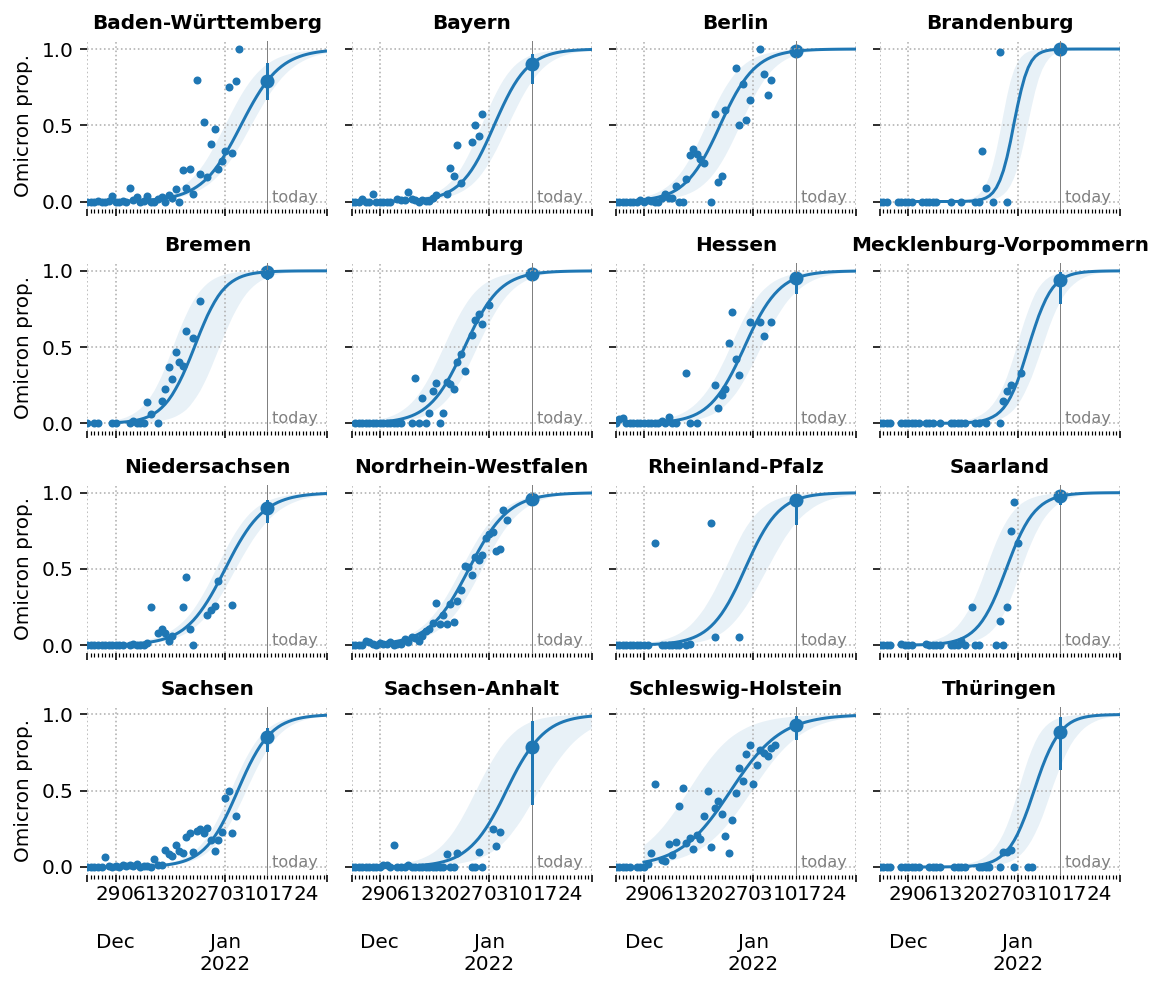

In [21]:
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    prop_bl.loc[r,:,0.5][0].plot(label=r, ax=ax[i])
    ax[i].fill_between(prop_bl.loc[r,:,0.05][0].index, prop_bl.loc[r,:,0.05][0], prop_bl.loc[r,:,0.95][0], alpha=0.1)
    ax[i].axvline(np.datetime64("today"), color='grey', lw=0.5)
    ax[i].text(np.datetime64("today"),0.0, " today", size=8, color='grey')
    ax[i].plot(np.repeat(np.datetime64("today"),2), prop_bl.loc[r,np.datetime64("today"),[0.05,0.95]], c='C0')
    ax[i].scatter(np.datetime64("today"), prop_bl.loc[r,np.datetime64("today"),0.5], c='C0')
    ax[i].grid(ls=":")
    omi_bl.loc[r]['prop'][omi_bl.loc[r]['all']>=3].plot(ls="", marker=".", label=r, ax=ax[i], c='C0')
    ax[i].set_title(r, size=10, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Omicron prop.")

    for a in ax[i].spines.values():
        a.set_visible(False)
plt.tight_layout()
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

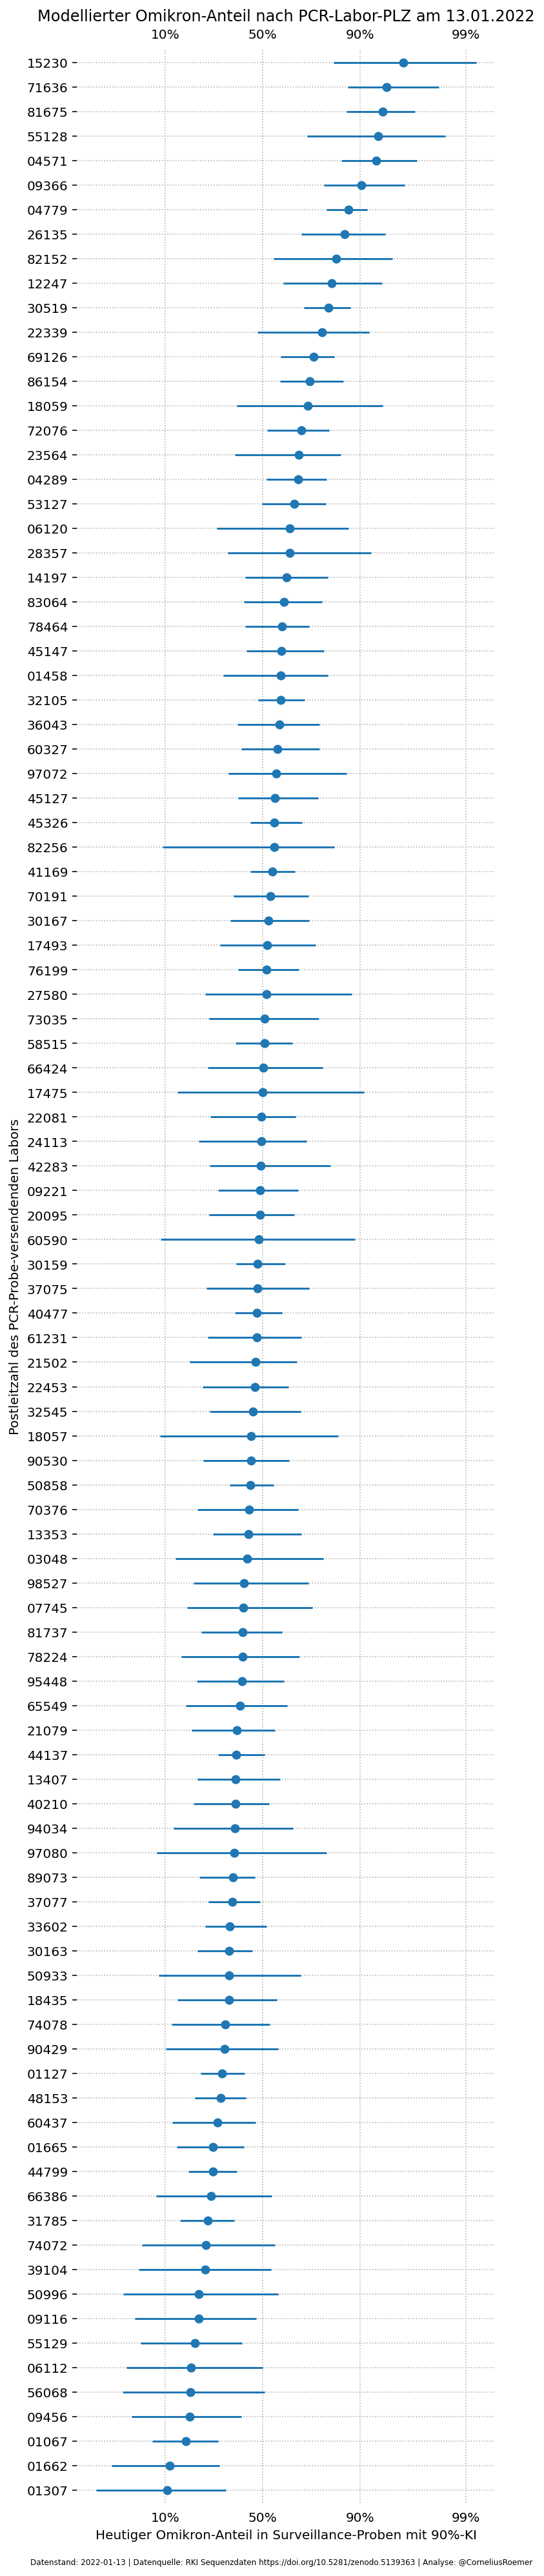

In [22]:
pdf = pd.DataFrame(mcmc_summary['a_lab'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
#sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

Text(0.5, -0.01, 'Datenstand: 2022-01-13 | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer')

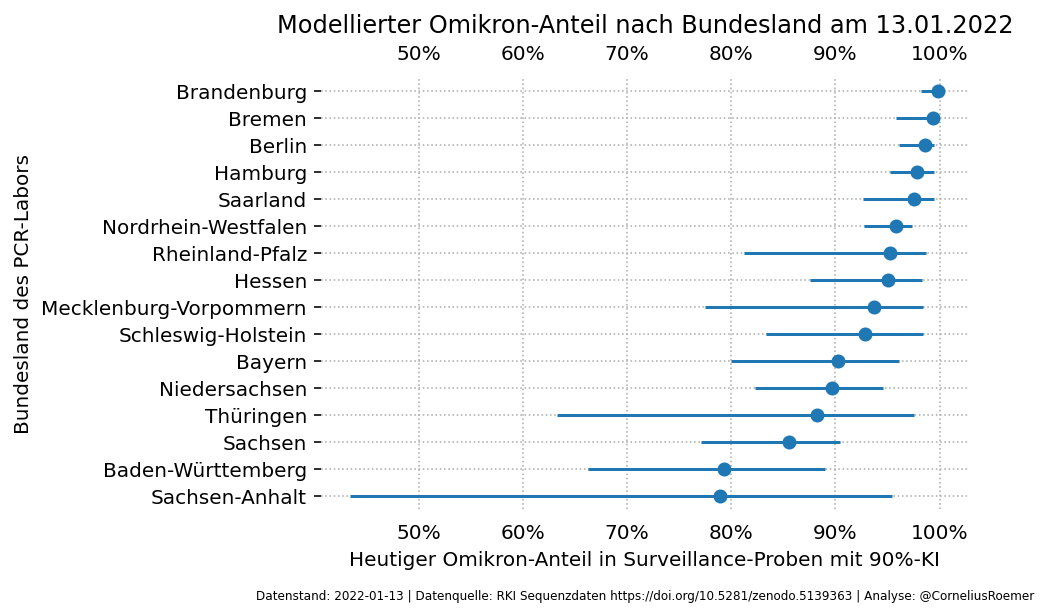

In [23]:
pdf = pd.DataFrame(mcmc_summary['a_area'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
#sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
#ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
#fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

## Maps
Map postcodes to Bundesländer (~5 Minutes)

In [24]:
bl = plz.dissolve(by = 'bundesland')
bl.geometry = bl.simplify(1e-2, preserve_topology=False)

In [25]:
bl['land'] = "Deutschland"

In [26]:
bl

geometry  \
bundesland                                                                  
#N/A                    POLYGON ((6.83623 49.21127, 6.85915 49.22275, ...   
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...   
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...   
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...   
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...   
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...   
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...   
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...   
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...   
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...   
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...   
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...   
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...   
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...   
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...   
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...   
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...   

                        OBJECTID    plz       ags                ort  \
bundesland                                                             
#N/A                         409  57540      #N/A               #N/A   
Baden-Württemberg           1129  79588  08336014   Efringen-Kirchen   
Bayern                      3150  63791  09671114  Karlstein am Main   
Berlin                      8042  14109  11000000             Berlin   
Brandenburg                 6380  19309  12070236               Lanz   
Bremen                      2400  28777  04011000             Bremen   
Hamburg                     2308  27499  02000000            Hamburg   
Hessen                      1486  65391  06439010              Lorch   
Mecklenburg-Vorpommern      5574  19258  13076009        Bengerstorf   
Niedersachsen                253  26757  03457002             Borkum   
Nordrhein-Westfalen            1  52538  05370008            Gangelt   
Rheinland-Pfalz               24  54689  07232001             Affler   
Saarland                      92  66706  10042115               Perl   
Sachsen                     7046  08538  14523450         Weischlitz   
Sachsen-Anhalt              5540  38835  15085230         Osterwieck   
Schleswig-Holstein          1625  27498  01056025          Helgoland   
Thüringen                   4517  36419  16063011            Buttlar   

                                            landkreis  einwohner  \
bundesland                                                         
#N/A                                             #N/A        0.0   
Baden-Württemberg                   Landkreis Lörrach     8205.0   
Bayern                        Landkreis Aschaffenburg     8023.0   
Berlin                                           None    10049.0   
Brandenburg                        Landkreis Prignitz     3684.0   
Bremen                                           None    12969.0   
Hamburg                                          None        8.0   
Hessen                          Rheingau-Taunus-Kreis     3994.0   
Mecklenburg-Vorpommern  Landkreis Ludwigslust-Parchim    15989.0   
Niedersachsen                          Landkreis Leer     5207.0   
Nordrhein-Westfalen                   Kreis Heinsberg    21390.0   
Rheinland-Pfalz               Eifelkreis Bitburg-Prüm     2326.0   
Saarland                      Landkreis Merzig-Wadern     7791.0   
Sachsen                                 Vogtlandkreis     6264.0   
Sachsen-Anhalt                         Landkreis Harz    10404.0   
Schleswig-Holstein                    Kreis Pinneberg     1407.0   
Thüringe

In [27]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


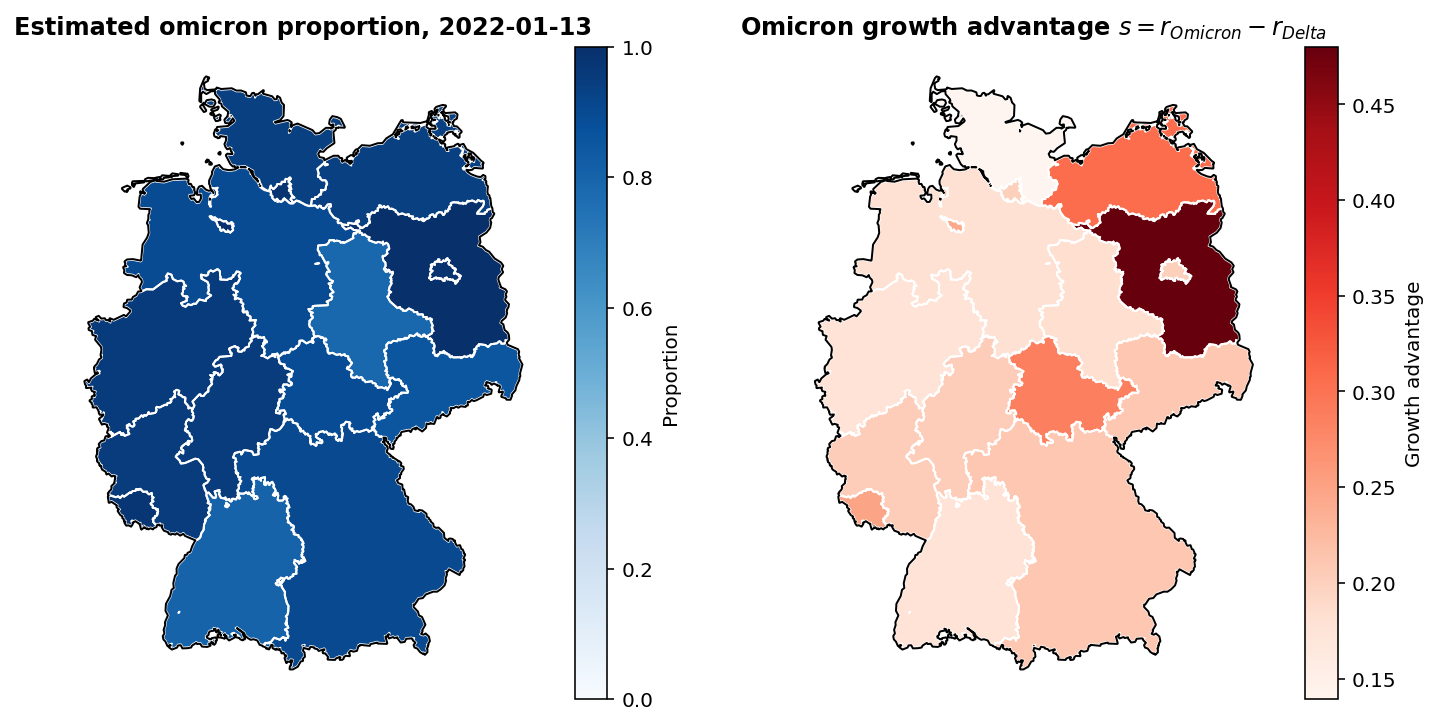

In [28]:
#sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf = pd.DataFrame({'prop':expit(mcmc_summary['a_area']['mean']),
                    'prop_5%':expit(mcmc_summary['a_area']['5.0%']),
                    'prop_95%':expit(mcmc_summary['a_area']['95.0%']),
                    's': mcmc_summary['b']['mean'],
                    's_sd': mcmc_summary['b']['std']},
                   index=df_filtered.bundesland.values.categories)

b = bl.merge(pdf, left_index=True, right_index=True)
b.plot("prop", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Proportion"},
            figsize=(6,6),
            ax = ax[0],
            vmin = 0,
           vmax = 1
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated omicron proportion, {np.datetime64('today')}", weight='bold')

b.plot("s", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Growth advantage"},
            figsize=(6,6),
       ax = ax[1]
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title("Omicron growth advantage $s = r_{Omicron} - r_{Delta}$", weight='bold')
fig.savefig("plots/omi_share_map.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [29]:
bar = omi_bl.reset_index()
bar['week'] = bar.date - pd.to_timedelta(bar.date.dt.dayofweek, unit='d')
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

bundesland         week      
Baden-Württemberg  2021-11-15    0.000000
                   2021-11-22    0.000652
                   2021-11-29    0.006645
                   2021-12-06    0.009434
                   2021-12-13    0.018106
                                   ...   
Thüringen          2021-12-06    0.000000
                   2021-12-13    0.000000
                   2021-12-20    0.000000
                   2021-12-27    0.092784
                   2022-01-03    0.000000
Name: prop, Length: 128, dtype: float64

(2707.0, 2716.0)

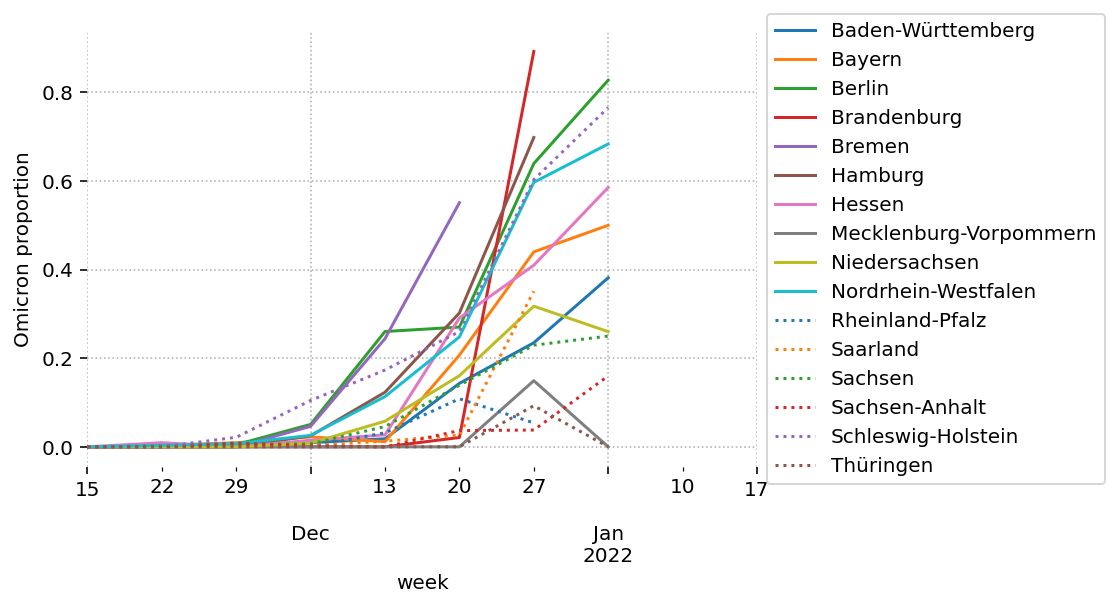

In [30]:
for i,r in enumerate(bar.index.levels[0]):
    bar.loc[r]['prop'].plot( label=r, ls = "-" if i <10 else ":")
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Omicron proportion")
plt.xlim((None,np.datetime64("today")))

In [31]:
bar.loc[:,'2021-12-20':,:]

all  omi  days  sending_area  \
bundesland             week                                        
Baden-Württemberg      2021-12-20   405   58 -1764           588   
                       2021-12-27   677  159 -1176           588   
                       2022-01-03   228   87  -480           420   
Bayern                 2021-12-20   464   96 -1764           714   
                       2021-12-27   325  143 -1176           714   
                       2022-01-03     4    2  -480           510   
Berlin                 2021-12-20    37   10  -588            28   
                       2021-12-27    61   39  -392            28   
                       2022-01-03    29   24  -160            20   
Brandenburg            2021-12-20    95    2  -294             7   
                       2021-12-27    65   58  -196             7   
                       2022-01-03     0    0   -80             5   
Bremen                 2021-12-20    98   54  -294            28   
                       2021-12-27     0    0  -196            28   
                       2022-01-03     0    0   -80            20   
Hamburg                2021-12-20   331  100 -1029            98   
                       2021-12-27   371  259  -686            98   
                       2022-01-03     0    0  -280            70   
Hessen                 2021-12-20   117   34  -735           189   
                       2021-12-27    61   25  -490           189   
                       2022-01-03    41   24  -200           135   
Mecklenburg-Vorpommern 2021-12-20   113    0 -1176            56   
                       2021-12-27   134   20  -784            56   
                       2022-01-03     4    0  -320            40   
Niedersachsen          2021-12-20   162   26 -1323           182   
                       2021-12-27   126   40  -882           182   
                       2022-01-03    50   13  -360           130   
Nordrhein-Westfalen    2021-12-20  1080  268 -2793           546   
                       2021-12-27   799  477 -1862           546   
                       2022-01-03   256  175  -760           390   
Rheinland-Pfalz        2021-12-20    83    9  -441           105   
                       2021-12-27    37    2  -294           105   
                       2022-01-03     0    0  -120            75   
Saarland               2021-12-20    38    1  -294            84   
                       2021-12-27   168   59  -196            84   
                       2022-01-03     0    0   -80            60   
Sachsen                2021-12-20  1079  150 -2205             0   
                       2021-12-27   375   86 -1470             0   
                       2022-01-03    68   17  -600             0   
Sachsen-Anhalt         2021-12-20   109    4  -441            21   
                       2021-12-27   132    5  -294            21   
                       2022-01-03    50    8  -120            15   
Schleswig-Holstein     2021-12-20   415  108  -588            56   
                       2021-12-27   801  483  -392            56   
                       2022-01-03   316  242  -160            40   
Thüringen              2021-12-20   166    0  -588           189   
                       2021-12-27   194   18  -392           189   
                       2022-01-03     6    0  -160           135   

                                   sending_pc_ID      prop  
bundesland             week                                 
Baden-Württemberg      2021-12-20           6804  0.143210  
                       2021-12-27           6804  0.234860  
                       2022-01-03           4860  0.381579  
Bayern                 2021-12-20           7728  0.206897  
                       2021-12-27           7728  0.440000  
                       2022-01-03           5520  0.500000  
Berlin                 2021-12-20            518  0.270270  
                       2021-12-27            518  0.639344  
                       20

In [32]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [33]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [34]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [35]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-08         616
                  2022-01-09         372
                  2022-01-10         349
                  2022-01-11         531
                  2022-01-12         402

[11176 rows x 1 columns]

Text(0, 0.5, 'cases')

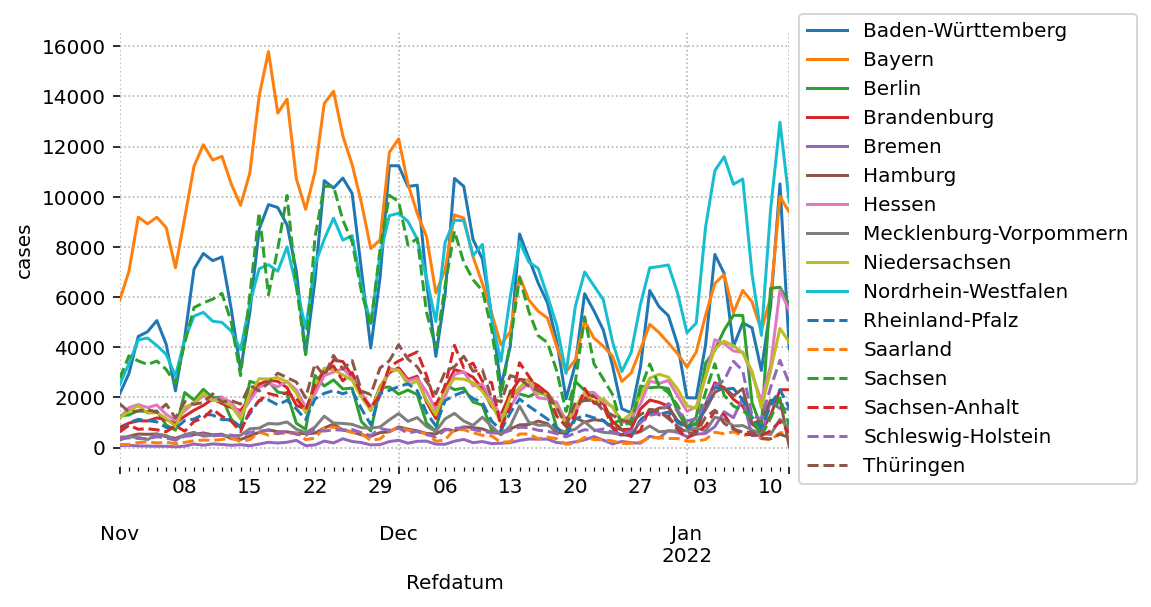

In [36]:
for i,r in enumerate(cases_land.index.levels[0]):
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=r, ls="-" if i<10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

In [37]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1284           168           1944   
                  2021-11-22  1533    1 -4116           588           6804   
                  2021-11-29   903    6 -3528           588           6804   
                  2021-12-06   954    9 -2940           588           6804   
                  2021-12-13   718   13 -2352           588           6804   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-06   143    0  -980           189           2184   
                  2021-12-13   240    0  -784           189           2184   
                  2021-12-20   166    0  -588           189           2184   
                  2021-12-27   194   18  -392           189           2184   
                  2022-01-03     6    0  -160           135           1560   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.018106  
...                                ...  
Thüringen         2021-12-06  0.000000  
                  2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.092784  
                  2022-01-03  0.000000  

[128 rows x 6 columns]

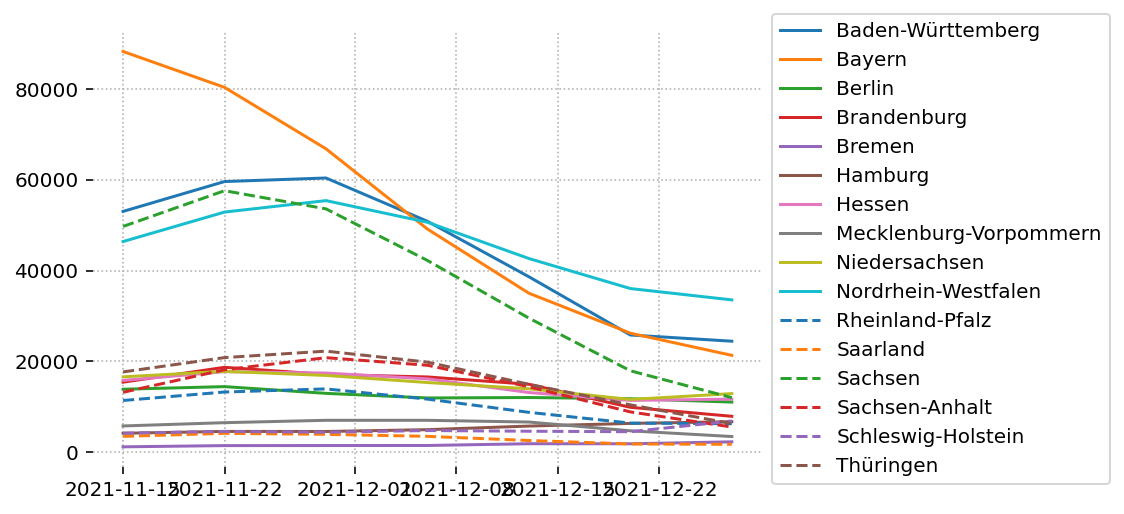

In [38]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Omicron cases')

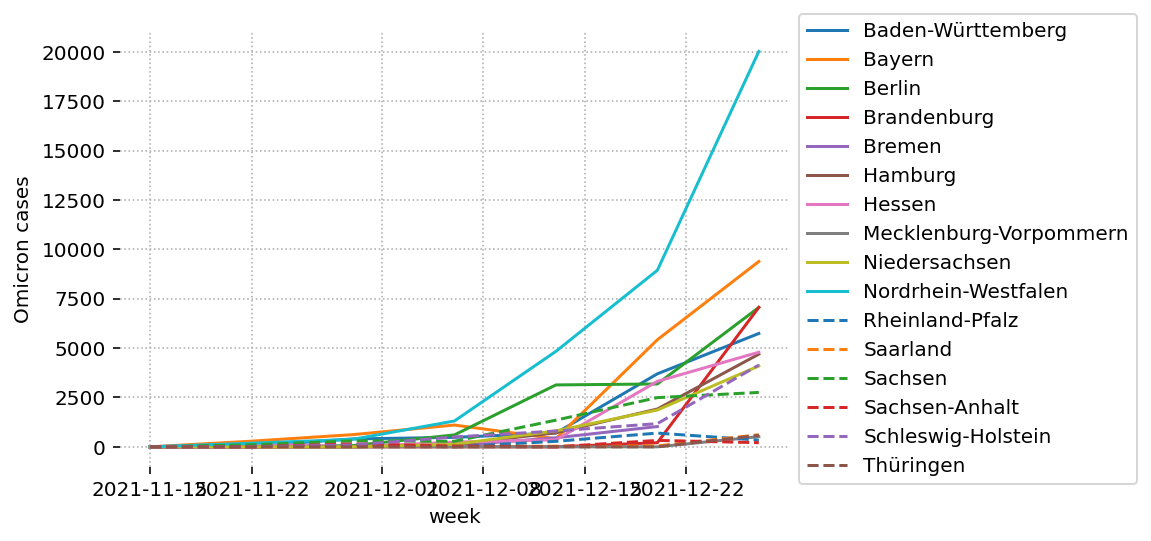

In [39]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

In [40]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1284           168           1944   
                  2021-11-22  1533    1 -4116           588           6804   
                  2021-11-29   903    6 -3528           588           6804   
                  2021-12-06   954    9 -2940           588           6804   
                  2021-12-13   718   13 -2352           588           6804   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-06   143    0  -980           189           2184   
                  2021-12-13   240    0  -784           189           2184   
                  2021-12-20   166    0  -588           189           2184   
                  2021-12-27   194   18  -392           189           2184   
                  2022-01-03     6    0  -160           135           1560   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.018106  
...                                ...  
Thüringen         2021-12-06  0.000000  
                  2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.092784  
                  2022-01-03  0.000000  

[128 rows x 6 columns]

In [41]:
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-08         616
                  2022-01-09         372
                  2022-01-10         349
                  2022-01-11         531
                  2022-01-12         402

[11176 rows x 1 columns]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


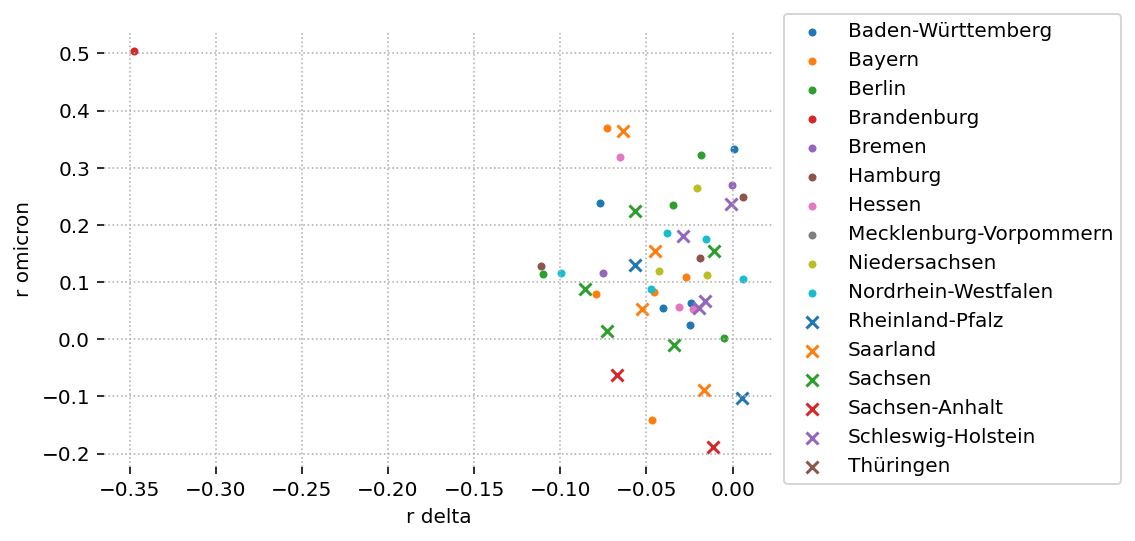

In [42]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=r, marker = "." if i <10 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [43]:
c = cases_land.loc[:,"2021-12-08":"2021-12-21",:] / cases_land.loc[:,"2021-12-01":"2021-12-14",:].values
foo = np.log(c).mean(level=0).rename(columns={'AnzahlFall':'r'}) / 7
foo['r_sd'] = np.log(c).std(level=0).values / 7

In [44]:
foo = foo.merge(pdf, left_index=True, right_index=True)

<AxesSubplot:xlabel='r', ylabel='s'>

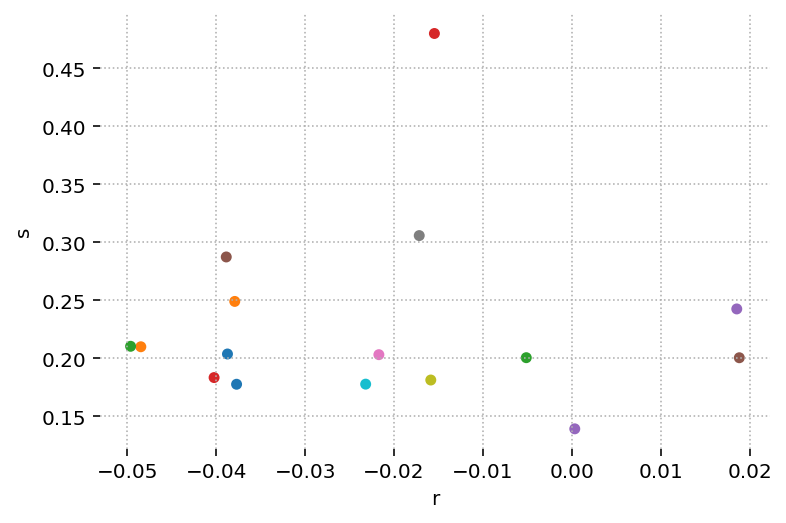

In [45]:
foo.plot.scatter("r","s", c = [f'C{i}' for i in range(foo.shape[0])])
#plt.legend()

Text(0, 0.5, 'Growth rate Omicron')

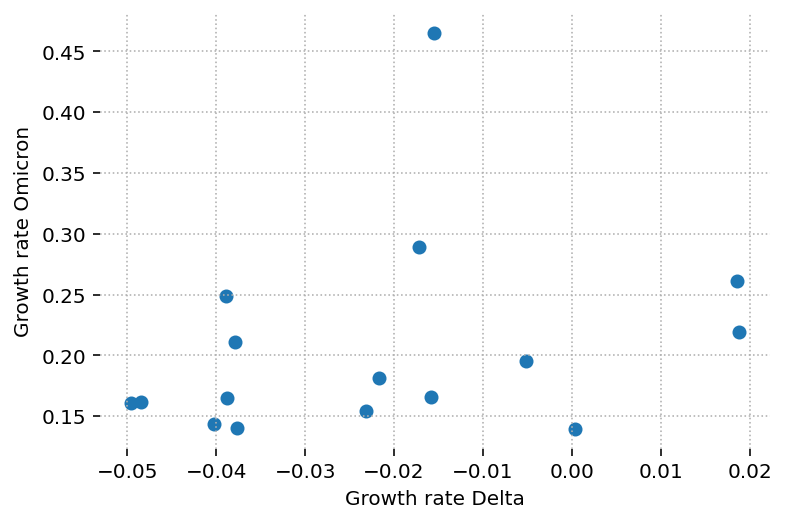

In [46]:
plt.scatter(foo['r'], foo['s'] + foo['r'])
plt.xlabel("Growth rate Delta")
plt.ylabel("Growth rate Omicron")

In [47]:
foo.to_csv(f"Germany_SGTF_{np.datetime64('today')}.csv")

In [48]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [49]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

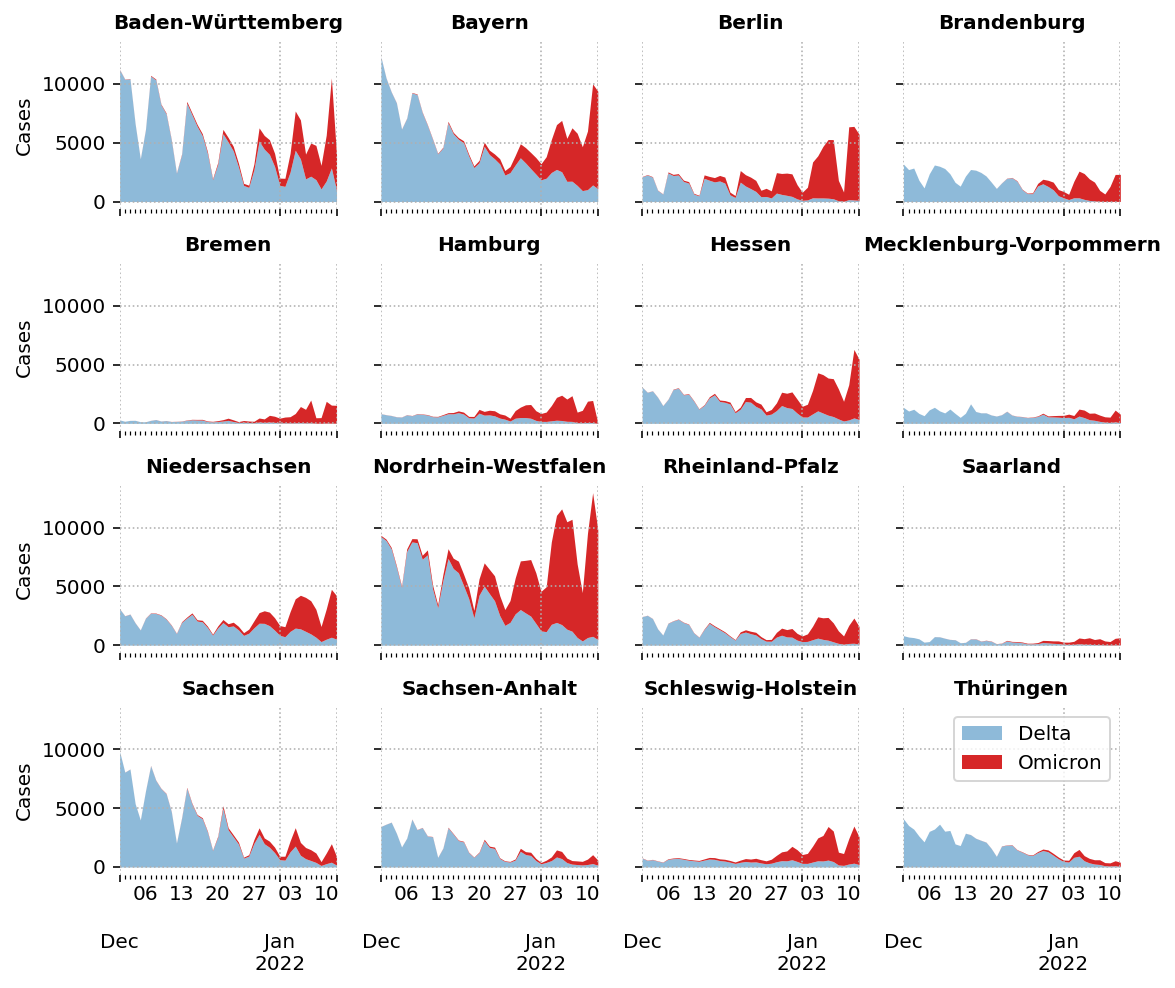

In [50]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] 
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    #ax[i].plot(s.index, s, ls="-", c='C0')
    #s.iloc[-7:-1]
    #ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='C3')
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()

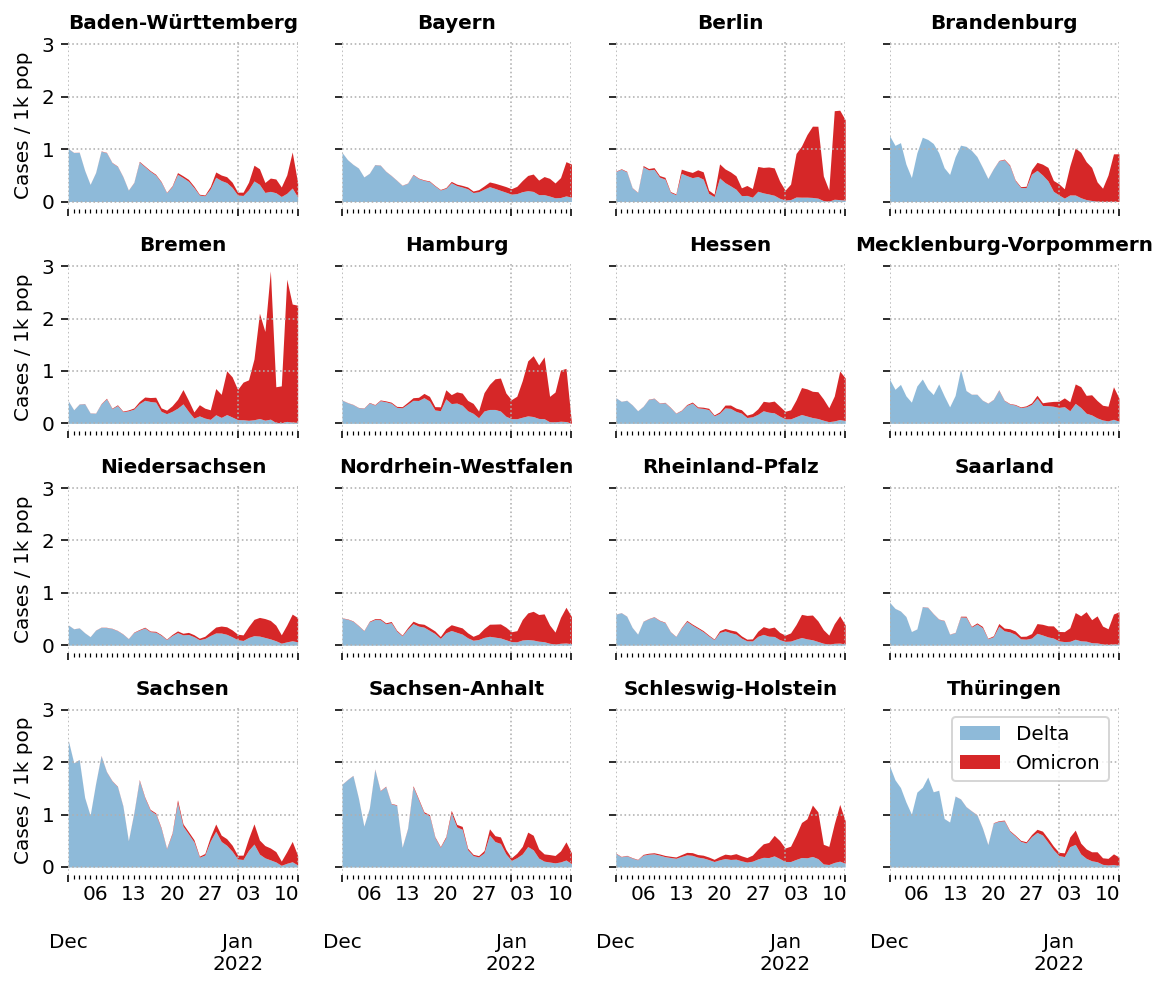

In [51]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

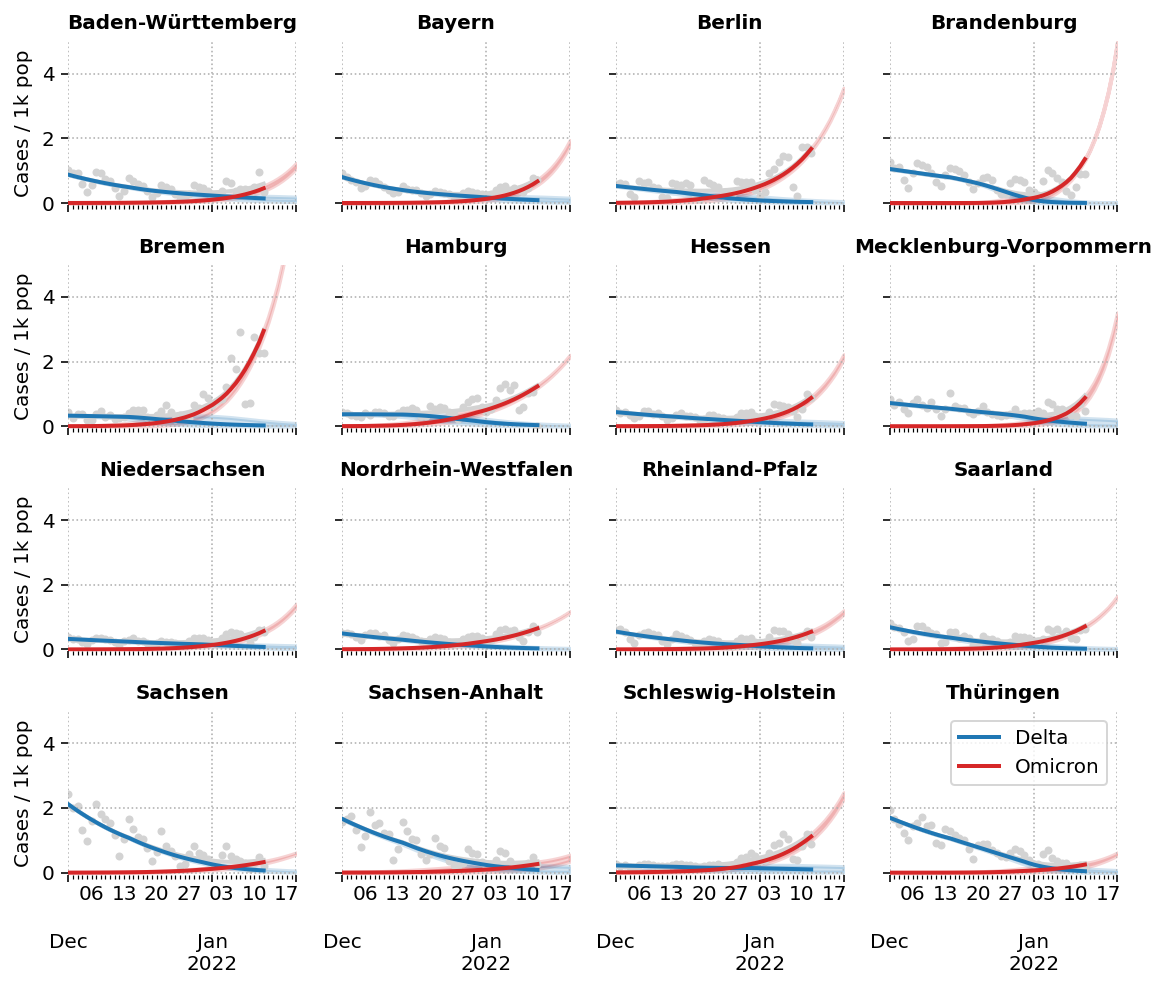

In [52]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
e = {}
f = {}
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    #ax[i].fill_between(s.index, s, color='C0', alpha=.5, lw=0, label="Delta")
    #ax[i].fill_between(x.index, s*x[0.5]/x[0.5], s/(1-x[0.5]), color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='lightgrey', label="", lw=2)
    ax[i].plot(s.index, s, ls="-", c='C0', label="Delta", lw=2)
    ax[i].plot(x.index, s/(1-x[0.5]) * x[.5], ls="-", c='C3', label="Omicron", lw=2)
    
    s1 = pd.Series(np.exp(np.log(s).diff().iloc[-7:].mean() * np.arange(1,8) + np.log(s)[-1]), index=s.index[-1] + np.arange(1,8).astype("timedelta64[D]"))
    #ax[i].plot(x.index, s1/(1-x[0.5]), ls=":", c='lightgrey', label="", lw=2)
    #ax[i].plot(s1.index, s1, ls=":", c='C0', label="", lw=2)
    #ax[i].plot(x.index, s1/(1-x[0.5]) * x[.5], ls=":", c='C3', label="", lw=2)
    
    s = pd.concat([s,s1])
    ax[i].fill_between(x.index, s/(1-x[0.5]) * x[0.05] , s/(1-x[0.5]) * x[0.95], color='C3', lw=2, alpha=0.2)
    ax[i].fill_between(x.index, s/(1-x[0.5]) * (1-x[0.05]) , s/(1-x[0.5]) * (1-x[0.95]) , color='C0', lw=2, alpha=0.2)

    
    ax[i].scatter(y.index, y, marker=".",c='lightgrey', label="")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    ax[i].set_xlim((None, s1.index[-1]))
    ax[i].set_ylim((None, 5))
    for a in ax[i].spines.values():
        a.set_visible(False)
    e[r] = s/(1-x[0.5][s.index]) * capita[r] / 1000
    f[r] = s * capita[r] / 1000
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area_fit.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [53]:
1 / (1 + pd.DataFrame(f).sum(1) /pd.DataFrame(e).sum(1))

2021-12-01    0.500897
2021-12-02    0.501084
2021-12-03    0.501309
2021-12-04    0.501581
2021-12-05    0.501910
2021-12-06    0.502306
2021-12-07    0.502787
2021-12-08    0.503368
2021-12-09    0.504068
2021-12-10    0.504912
2021-12-11    0.505937
2021-12-12    0.507170
2021-12-13    0.508659
2021-12-14    0.510442
2021-12-15    0.512555
2021-12-16    0.515077
2021-12-17    0.518102
2021-12-18    0.521709
2021-12-19    0.525974
2021-12-20    0.531027
2021-12-21    0.536986
2021-12-22    0.544011
2021-12-23    0.552155
2021-12-24    0.561628
2021-12-25    0.572589
2021-12-26    0.585202
2021-12-27    0.599632
2021-12-28    0.615869
2021-12-29    0.633872
2021-12-30    0.653668
2021-12-31    0.675072
2022-01-01    0.697462
2022-01-02    0.720675
2022-01-03    0.744333
2022-01-04    0.768053
2022-01-05    0.791481
2022-01-06    0.814092
2022-01-07    0.835622
2022-01-08    0.855738
2022-01-09    0.874368
2022-01-10    0.891305
2022-01-11    0.906525
2022-01-12    0.920015
2022-01-13 

In [54]:
pd.DataFrame(e).sum(1)

2021-12-01     60899.032280
2021-12-02     58511.198164
2021-12-03     56225.562460
2021-12-04     54034.398460
2021-12-05     51930.161607
2021-12-06     49909.290101
2021-12-07     47974.495311
2021-12-08     46130.338607
2021-12-09     44380.275818
2021-12-10     42726.483836
2021-12-11     41172.318076
2021-12-12     39718.582197
2021-12-13     38374.496153
2021-12-14     37151.303950
2021-12-15     35723.977106
2021-12-16     34329.851826
2021-12-17     33018.422861
2021-12-18     31830.108920
2021-12-19     30784.096721
2021-12-20     29869.557494
2021-12-21     29054.137314
2021-12-22     28328.983610
2021-12-23     27697.126951
2021-12-24     27188.694616
2021-12-25     26825.075094
2021-12-26     26634.817702
2021-12-27     26644.610848
2021-12-28     26851.365613
2021-12-29     27239.842063
2021-12-30     27819.852228
2021-12-31     28303.404482
2022-01-01     29023.826376
2022-01-02     30061.915521
2022-01-03     31442.203891
2022-01-04     33194.872044
2022-01-05     35363